# Data Acquisition

In [113]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [114]:
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

In [115]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [116]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import SpatialDropout1D
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras.preprocessing.sequence import pad_sequences

In [117]:
df = pd.read_csv("/content/Restaurant reviews.csv")
df.head()

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0


In [118]:
print(df["Review"][2])

A must try.. great food great ambience. Thnx for the service by Pradeep and Subroto. My personal recommendation is Penne Alfredo Pasta:) ....... Also the music in the background is amazing.


In [119]:
df.shape

(10000, 7)

# Data Pre-processing

In [120]:
df.dtypes

Restaurant    object
Reviewer      object
Review        object
Rating        object
Metadata      object
Time          object
Pictures       int64
dtype: object

In [121]:
# Checking for null values
df.isnull().sum()

Restaurant     0
Reviewer      38
Review        45
Rating        38
Metadata      38
Time          38
Pictures       0
dtype: int64

In [122]:
# Deleting null values:
df = df.dropna()
df.shape

(9955, 7)

In [123]:
# Checking various values present in the column
df["Rating"].value_counts()

5       3826
4       2373
1       1735
3       1192
2        684
4.5       69
3.5       47
2.5       19
1.5        9
Like       1
Name: Rating, dtype: int64

In [124]:
# Replacing 'Like' with 5 rating
df["Rating"] = df["Rating"].replace("Like", 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [125]:
# Converting to float type
df["Rating"] = df["Rating"].astype("float")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [126]:
# Taking a part of the data for sentiment analysis
ratings = df[["Review", "Rating"]]
ratings.head()

,Review,Rating
0,"The ambience was good, food was quite good . h...",5.0
1,Ambience is too good for a pleasant evening. S...,5.0
2,A must try.. great food great ambience. Thnx f...,5.0
3,Soumen das and Arun was a great guy. Only beca...,5.0
4,Food is good.we ordered Kodi drumsticks and ba...,5.0


In [127]:
# Checking data types
ratings.dtypes

Review     object
Rating    float64
dtype: object

In [128]:
# Replacing all values under 4 with 0 and the rest with 1
ratings["Rating"] = np.where(ratings['Rating']<4, 0, 1)
ratings.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Review,Rating
0,"The ambience was good, food was quite good . h...",1
1,Ambience is too good for a pleasant evening. S...,1
2,A must try.. great food great ambience. Thnx f...,1
3,Soumen das and Arun was a great guy. Only beca...,1
4,Food is good.we ordered Kodi drumsticks and ba...,1


In [129]:
# Cleaning the reviews to get rid of white spaces and converting them to lower format
clean = re.compile('[^a-z]+')

def cleaning(text):
    text = str(text)
    text = text.lower() 
    #text = text.strip()  
    text = clean.sub(' ', text).strip()
    return text

In [130]:
ratings['Review'] = ratings['Review'].apply(cleaning)
ratings.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Review,Rating
0,the ambience was good food was quite good had ...,1
1,ambience is too good for a pleasant evening se...,1
2,a must try great food great ambience thnx for ...,1
3,soumen das and arun was a great guy only becau...,1
4,food is good we ordered kodi drumsticks and ba...,1


In [131]:
def processing(text):
  text = str(text)
  tokens = word_tokenize(text)
  stop_words = set(stopwords.words('english'))
  text = ' '.join([i for i in tokens if not i in stop_words])
  return text

In [132]:
ratings['Review'] = ratings['Review'].apply(processing)
ratings.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Review,Rating
0,ambience good food quite good saturday lunch c...,1
1,ambience good pleasant evening service prompt ...,1
2,must try great food great ambience thnx servic...,1
3,soumen das arun great guy behavior sincerety g...,1
4,food good ordered kodi drumsticks basket mutto...,1
5,ambiance good service good food apradeecp subr...,1
6,nice place ambience different food ordered tas...,1
7,well reading many reviews finally visited plac...,1
8,excellent food specially like spicy food court...,1
9,came birthday treat close friend perfect place...,1


In [133]:
lemmatizer = WordNetLemmatizer()

In [134]:
def lemmatizing(text):
  data = word_tokenize(text)
  result = ' '.join([lemmatizer.lemmatize(w) for w in data])
  return result

In [135]:
ratings['Review'] = ratings['Review'].apply(lemmatizing)
ratings.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Review,Rating
0,ambience good food quite good saturday lunch c...,1
1,ambience good pleasant evening service prompt ...,1
2,must try great food great ambience thnx servic...,1
3,soumen da arun great guy behavior sincerety go...,1
4,food good ordered kodi drumstick basket mutton...,1


# Visualisations

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of reviews for each rating')

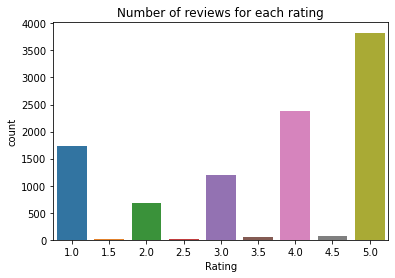

In [136]:
sns.countplot(df['Rating']).set_title("Number of reviews for each rating")

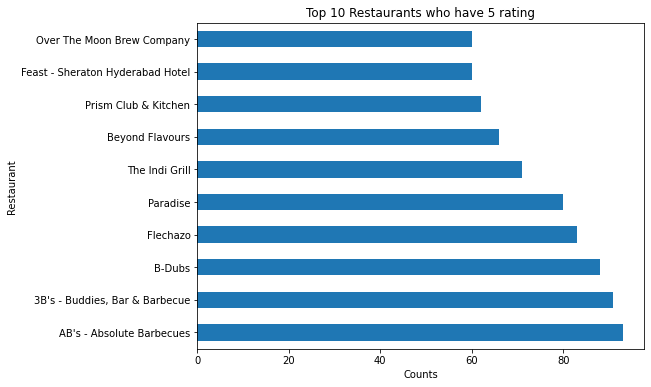

In [137]:
sample = pd.DataFrame()
# Copying only 5 rating data
sample['Restaurant'] = df['Restaurant'].where(df['Rating'] == 5.0)
sample = sample.dropna()
sample['Restaurant'].value_counts()[:10].plot(kind = 'barh', figsize = (8, 6), rot = 0)
plt.title('Top 10 Restaurants who have 5 rating')
plt.xlabel('Counts')
plt.ylabel('Restaurant')
plt.show()

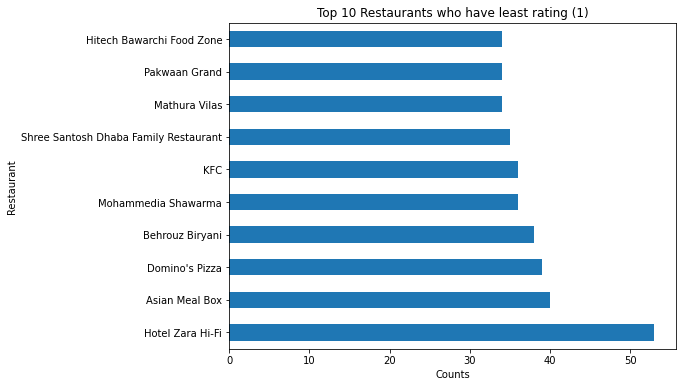

In [138]:
sample2 = pd.DataFrame()
# Copying only 1 rating data
sample2['Restaurant'] = df['Restaurant'].where(df['Rating'] == 1.0)
sample2 = sample2.dropna()
sample2['Restaurant'].value_counts()[:10].plot(kind = 'barh', figsize = (8, 6), rot = 0)
plt.title('Top 10 Restaurants who have least rating (1)')
plt.xlabel('Counts')
plt.ylabel('Restaurant')
plt.show()

# Dividing into Train and Test Splits

In [139]:
# Separating input variable from the target variable
input = ratings['Review']
target = ratings['Rating']

In [140]:
x_train, x_test, y_train, y_test = train_test_split(input, target, test_size = 0.2, random_state = 0)

In [141]:
print("Length of x_train: ", len(x_train))
print("Length of y_train:", len(y_train))
print("Length of x_test: ", len(x_test))
print("Length of y_test:", len(y_test))

Length of x_train:  7964
Length of y_train: 7964
Length of x_test:  1991
Length of y_test: 1991


# Data Transformation

## Using Count Vectors

In [142]:
count_vector = CountVectorizer(analyzer = 'word', token_pattern = r'\w{1,}')
count_vector.fit(x_train)
# Transforming the train and test dataset
x_train_countvector = count_vector.transform(x_train)
x_test_countvector = count_vector.transform(x_test)

## Using Word-level  TF IDF Vectors 

In [143]:
tfidf_vector = TfidfVectorizer(analyzer = 'word', token_pattern = r'\w{1,}', max_features = 5000)
tfidf_vector.fit(x_train)
x_train_tfidf =  tfidf_vector.transform(x_train)
x_test_tfidf =  tfidf_vector.transform(x_test)

## Using N-gram level Vectors

In [144]:
tfidf_vector_ngram = TfidfVectorizer(analyzer = 'word', token_pattern = r'\w{1,}', ngram_range = (1,2), max_features = 5000)
tfidf_vector_ngram.fit(x_train)
x_train_tfidf_ngram =  tfidf_vector_ngram.transform(x_train)
x_test_tfidf_ngram =  tfidf_vector_ngram.transform(x_test)

## Using Character level Vectors

In [145]:
tfidf_vector_ngram_chars = TfidfVectorizer(analyzer = 'char', ngram_range = (1,2), max_features = 5000)
tfidf_vector_ngram_chars.fit(x_train)
x_train_tfidf_ngram_char =  tfidf_vector_ngram_chars.transform(x_train)
x_test_tfidf_ngram_char =  tfidf_vector_ngram_chars.transform(x_test)

# Modelling

In [146]:
def modelling(model, vector_xtrain, vector_xtest):
    # Fitting the trained vector on the classifier
    model.fit(vector_xtrain, y_train)
    
    # Predicting on test data
    prediction = model.predict(vector_xtest)
    
    return accuracy_score(prediction, y_test)

## Naive Bayes

In [147]:
accuracy1 = modelling(MultinomialNB(), x_train_countvector, x_test_countvector) * 100
print("Accuracy for Naive Bayes on Count Vectors: ", accuracy1)

Accuracy for Naive Bayes on Count Vectors:  86.58965344048217


In [148]:
accuracy2 = modelling(MultinomialNB(), x_train_tfidf, x_test_tfidf) * 100
print("Accuracy for Naive Bayes on Word level TF-IDF: ", accuracy2)

Accuracy for Naive Bayes on Word level TF-IDF:  85.38422903063787


In [149]:
accuracy3 = modelling(MultinomialNB(), x_train_tfidf_ngram, x_test_tfidf_ngram) * 100
print("Accuracy for Naive Bayes on N-gram level vectors: ", accuracy3)

Accuracy for Naive Bayes on N-gram level vectors:  86.8407835258664


In [150]:
accuracy4 = modelling(MultinomialNB(), x_train_tfidf_ngram_char, x_test_tfidf_ngram_char) * 100
print("Accuracy for Naive Bayes on character level vectors: ", accuracy4)

Accuracy for Naive Bayes on character level vectors:  68.55851330989452


## Logistic Regression

In [151]:
accuracyl1 = modelling(LogisticRegression(), x_train_countvector, x_test_countvector) * 100
print("Accuracy for Logistic Regression on Count Vectors: ", accuracyl1)

Accuracy for Logistic Regression on Count Vectors:  85.93671521848317


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [152]:
accuracyl2 = modelling(LogisticRegression(), x_train_tfidf, x_test_tfidf) * 100
print("Accuracy for Logistic Regression on Word level TF-IDF: ", accuracyl2)

Accuracy for Logistic Regression on Word level TF-IDF:  87.64439979909594


In [153]:
accuracyl3 = modelling(LogisticRegression(), x_train_tfidf_ngram, x_test_tfidf_ngram) * 100
print("Accuracy for Logistic Regression on N-gram level vectors: ", accuracyl3)

Accuracy for Logistic Regression on N-gram level vectors:  87.4937217478654


In [154]:
accuracyl4 = modelling(LogisticRegression(), x_train_tfidf_ngram_char, x_test_tfidf_ngram_char) * 100
print("Accuracy for Logistic Regression on character level vectors: ", accuracyl4)

Accuracy for Logistic Regression on character level vectors:  82.01908588648921


## Support Vector Machine

In [155]:
accuracys1 = modelling(SVC(), x_train_countvector, x_test_countvector) * 100
print("Accuracy for SVM on Count Vectors: ", accuracys1)

Accuracy for SVM on Count Vectors:  85.6353591160221


In [156]:
accuracys2 = modelling(SVC(), x_train_tfidf, x_test_tfidf) * 100
print("Accuracy for SVM on Word level TF-IDF: ", accuracys2)

Accuracy for SVM on Word level TF-IDF:  87.29281767955801


In [157]:
accuracys3 = modelling(SVC(), x_train_tfidf_ngram, x_test_tfidf_ngram) * 100
print("Accuracy for SVM on N-gram level vectors: ", accuracys3)

Accuracy for SVM on N-gram level vectors:  87.44349573078854


In [158]:
accuracys4 = modelling(SVC(), x_train_tfidf_ngram_char, x_test_tfidf_ngram_char) * 100
print("Accuracy for SVM on character level vectors: ", accuracys4)

Accuracy for SVM on character level vectors:  84.07835258663988


## Random Forest

In [159]:
accuracyr1 = modelling(RandomForestClassifier(), x_train_countvector, x_test_countvector) * 100
print("Accuracy for Random Forest on Count Vectors: ", accuracyr1)

Accuracy for Random Forest on Count Vectors:  86.03716725263688


In [160]:
accuracyr2 = modelling(RandomForestClassifier(), x_train_tfidf, x_test_tfidf) * 100
print("Accuracy for Random Forest on Word level TF-IDF: ", accuracyr2)

Accuracy for Random Forest on Word level TF-IDF:  85.83626318432948


In [161]:
accuracyr3 = modelling(RandomForestClassifier(), x_train_tfidf_ngram, x_test_tfidf_ngram) * 100
print("Accuracy for Random Forest on N-gram level vectors: ", accuracyr3)

Accuracy for Random Forest on N-gram level vectors:  85.98694123556002


In [162]:
accuracyr4 = modelling(RandomForestClassifier(), x_train_tfidf_ngram_char, x_test_tfidf_ngram_char) * 100
print("Accuracy for Random Forest on character level vectors: ", accuracyr4)

Accuracy for Random Forest on character level vectors:  79.85936715218483


## Boosting

In [163]:
accuracyb1 = modelling(GradientBoostingClassifier(), x_train_countvector, x_test_countvector) * 100
print("Accuracy for Boosting on Count Vectors: ", accuracyb1)

Accuracy for Boosting on Count Vectors:  82.37066800602713


In [164]:
accuracyb2 = modelling(GradientBoostingClassifier(), x_train_tfidf, x_test_tfidf) * 100
print("Accuracy for Boosting on Word level TF-IDF: ", accuracyb2)

Accuracy for Boosting on Word level TF-IDF:  83.07383224510296


In [165]:
accuracyb3 = modelling(GradientBoostingClassifier(), x_train_tfidf_ngram, x_test_tfidf_ngram) * 100
print("Accuracy for Boosting on N-gram level vectors: ", accuracyb3)

Accuracy for Boosting on N-gram level vectors:  84.02812656956303


In [166]:
accuracyb4 = modelling(GradientBoostingClassifier(), x_train_tfidf_ngram_char, x_test_tfidf_ngram_char) * 100
print("Accuracy for Boosting on character level vectors: ", accuracyb4)

Accuracy for Boosting on character level vectors:  81.5670517327976


In [167]:
performance = {'Naive Bayes':[accuracy1, accuracy2, accuracy3, accuracy4], 'Logistic':[accuracyl1, accuracyl2, accuracyl3, accuracyl4], 'SVM':[accuracys1, accuracys2, accuracys3, accuracys4], 'Random Forest':[accuracyr1, accuracyr2, accuracyr3, accuracyr4], 'Boosting':[accuracyb1, accuracyb2, accuracyb3, accuracyb4]} 
accuracy = pd.DataFrame(performance, index =['Count Vectors', 'Word level TF IDF', 'N-gram vector', 'Character vector']) 
  
# print the data 
accuracy

,Naive Bayes,Logistic,SVM,Random Forest,Boosting
Count Vectors,86.589653,85.936715,85.635359,86.037167,82.370668
Word level TF IDF,85.384229,87.644400,87.292818,85.836263,83.073832
N-gram vector,86.840784,87.493722,87.443496,85.986941,84.028127
Character vector,68.558513,82.019086,84.078353,79.859367,81.567052


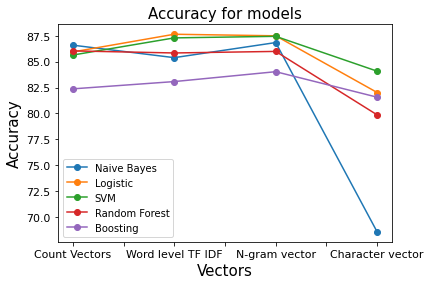

In [168]:
accuracy.plot.line(fontsize = 11, marker = 'o');
plt.title("Accuracy for models", fontsize = 15);
plt.xlabel("Vectors", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.show()

## Long Short Term Memory

In [169]:
# Maximum words that needs to be used
max_words = 10000
# Maximum length for sequence
max_length = 50
# Embedding dimension should be between 50 to 300
embedding = 100
token = Tokenizer(num_words = max_words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower = True)
token.fit_on_texts(input)
word_index = token.word_index
print('Unique tokens: ', len(word_index))

Unique tokens:  13265


In [170]:
from keras.preprocessing.sequence import pad_sequences

In [171]:
input = token.texts_to_sequences(input)
input = pad_sequences(input, maxlen = max_length)
print('Shape of data tensor:', input.shape)

Shape of data tensor: (9955, 50)


In [172]:
x2_train, x2_test, y2_train, y2_test = train_test_split(input, target, test_size = 0.2, random_state = 0)

In [173]:
print("Length of x_train: ", len(x2_train))
print("Length of y_train:", len(y2_train))
print("Length of x_test: ", len(x2_test))
print("Length of y_test:", len(y2_test))

Length of x_train:  7964
Length of y_train: 7964
Length of x_test:  1991
Length of y_test: 1991


In [174]:
print(x2_train.shape,y2_train.shape)
print(x2_test.shape,y2_test.shape)

(7964, 50) (7964,)
(1991, 50) (1991,)


In [177]:
model = Sequential()
model.add(Embedding(input_dim = max_words, output_dim = embedding, input_length = max_length))
model.add(LSTM(300, recurrent_dropout = 0.1))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())
history = model.fit(x2_train, y2_train, validation_data = (x2_test, y2_test), epochs = 5, batch_size = 64)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           1000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 300)               481200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 301       
Total params: 1,481,501
Trainable params: 1,481,501
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
125/125 [==============================] - 73s 566ms/step - loss: 0.4596 - accuracy: 0.7762 - val_loss: 0.3317 - val_accuracy: 0.8664
Epoch 2/5
125/125 [==============================] - 71s 566ms/step - loss: 0.2617 - accuracy

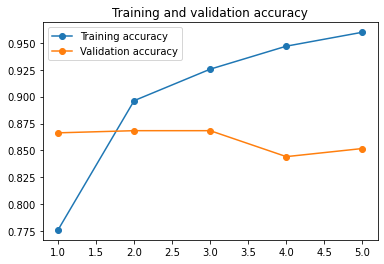

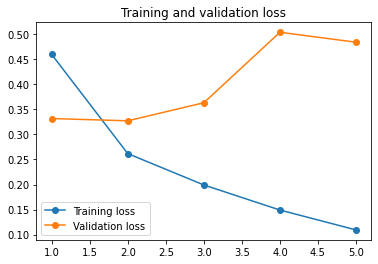

In [178]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, label = 'Training accuracy', marker = 'o')
plt.plot(epochs, val_acc, label = 'Validation accuracy', marker = 'o')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, label='Training loss', marker = 'o')
plt.plot(epochs, val_loss, label='Validation loss', marker = 'o')

plt.legend()

plt.show()